In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.formula.api as sfa
import statsmodels.api as sma

# VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from statsmodels.stats.diagnostic import linear_rainbow
from sklearn.model_selection import KFold,LeaveOneOut,cross_val_score
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE,RFECV

In [2]:
data=pd.read_csv('Concrete_Data.csv')

In [3]:
data

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


# ML Pipeline

### Data Preprocessing
* collection of data
* format 
* treat anomalies(missing values,outliers)
* encoding

### Feature Extraction
* feature transformation
* feature engineering
* feature selection
    * stepwise feature selection(SFS)
    * recursive feature elimination(RFE)

### Modeling
* model building
* model evaluation
    * train test data
    * scores(R2,adjusted R2)
    * errors(MSE,RMSE,MAE,MAPE)
    
### Optimization
* bias and variance trade off
* model validation techniques
* K-fold cross validation
* LOOCV(leave one out CV)
* fine tunning

# Data preprocessing

In [4]:
# descriptive analysis of data
print('NO. of Rows:',data.shape[0])
print('No. of columns:',data.shape[1])

NO. of Rows: 1030
No. of columns: 9


In [5]:
# descriptive summary 
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
Blast Furnace Slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
Fly Ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
Water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
Superplasticizer,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
Coarse Aggregate,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
Fine Aggregate,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
Age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
Concrete compressive strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


<Axes: >

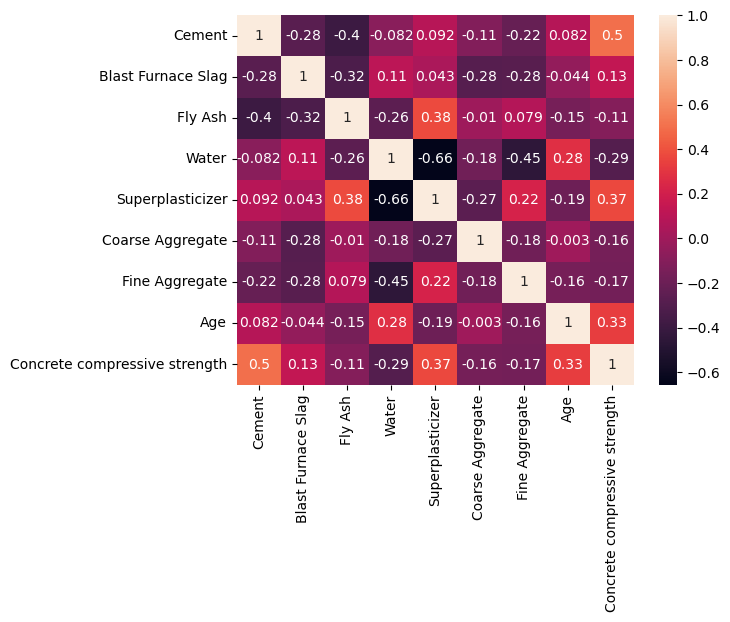

In [6]:
# covariance heatmap
sns.heatmap(data.corr(),annot=True)

In [7]:
# we have identified some duplicated rows in the dataset

data.duplicated().sum()

25

In [8]:
data.drop_duplicates(inplace=True)

In [9]:
data.shape

(1005, 9)

# univariate and bivariate analysis


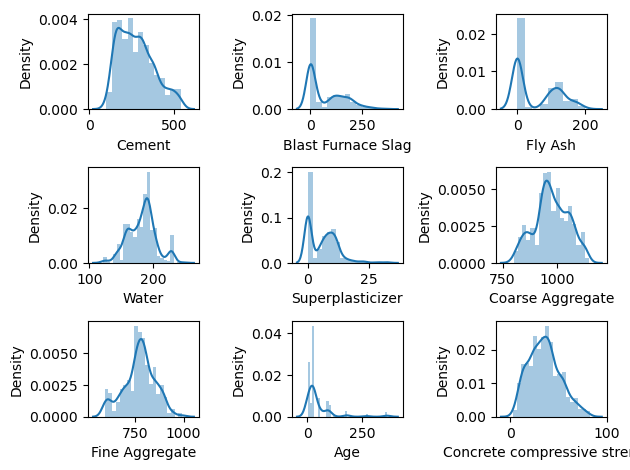

In [10]:
# univariate

t=1
for i in data.columns:
    plt.subplot(3,3,t)
    sns.distplot(data[i])
    t+=1
plt.tight_layout()
plt.show()

In [11]:
data.rename(columns={'Concrete compressive strength':'CCS'},inplace=True)

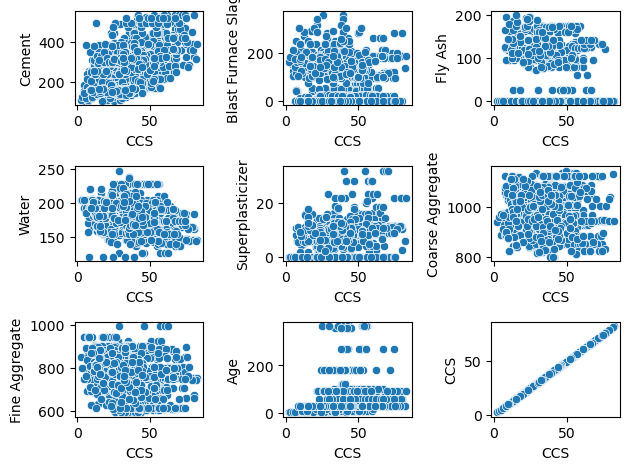

In [12]:
#bivariate
t=1
for i in data.columns:
    plt.subplot(3,3,t)
    sns.scatterplot(y=data[i],x=data['CCS'])
    t+=1
plt.tight_layout()
plt.show()

# treat anomalies

In [13]:
data.isnull().sum()

Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
CCS                   0
dtype: int64

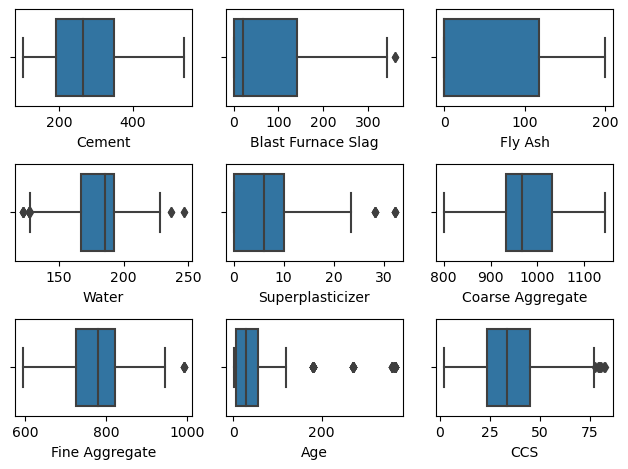

In [14]:
#bivariate
t=1
for i in data.columns:
    plt.subplot(3,3,t)
    sns.boxplot(x=data[i])
    t+=1
plt.tight_layout()
plt.show()

In [15]:
# since water and cement has high collinearity lets take cement to water ratio

data['Cement Water ratio']=data['Cement']/data['Water']
data.drop(columns=['Cement','Water'],inplace=True)

In [16]:
data['Course Fine ratio']=data['Coarse Aggregate']/data['Fine Aggregate']
data.drop(columns=['Coarse Aggregate','Fine Aggregate'],inplace=True)

In [17]:
data.drop(columns=['Course Fine ratio'],inplace=True)

# train-test split

In [18]:
#train-test split
x=data.drop(columns=['CCS'])
y=data['CCS']
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.75,random_state=2)

In [19]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(753, 5) (753,) (252, 5) (252,)


# 2 feature transformation

**why do we need feature transformation?**

    1. in case of skewed variable, we transform it to reduce the skewness
    2. if assumptions of linear regression are not met,transformation of skewed target variables will help making error term more compatible to the assumptions.
    3. it will transform the non-linear relation between the target and the independent variables to a linear relation. assumption of linearity or normality

**NOTE: comparison of model performance should be done using original units for the target variables and not the  units after transformation.**

**feature scaling-we dont scale the feature to have correct factors or slope for independent variables. this is usually done for distance based algoriths/models**

# 3 Modelling

### check for assumptions
* before checking the assumptions
    1. numeric dependend variables
    2. check for multi-colinearity


In [20]:
# since water and cement has high collinearity lets take cement to water ratio


In [21]:
# VIF
vif_list=[]
for i in range(x_train.shape[1]):
    vif_list.append(variance_inflation_factor(x_train.values,i))
pd.DataFrame({'Features names':x_train.columns,'VIF':vif_list}).sort_values(by='VIF',ascending=False)

,Features names,VIF
2,Superplasticizer,3.164567
4,Cement Water ratio,2.921064
1,Fly Ash,1.869333
3,Age,1.467144
0,Blast Furnace Slag,1.452220


In [22]:
# lets build a base model

x_train_c=sma.add_constant(x_train)
x_test_c=sma.add_constant(x_test)
base_model=sma.OLS(y_train,x_train_c).fit()
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CCS   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     221.4
Date:                Fri, 10 Nov 2023   Prob (F-statistic):          8.90e-145
Time:                        08:59:19   Log-Likelihood:                -2833.1
No. Observations:                 753   AIC:                             5678.
Df Residuals:                     747   BIC:                             5706.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -11.1731      1.805     -6.191      0.000     -14.716      -7.630
Blast Furnace Slag     0.0820      0.006     14.118      0.000       0.071       0.093
Fly Ash                0.0856      0.009      9.250      0.000       0.067       0.104
Superplasticizer       0.1808      0.090      2.017      0.044       0.005       0.357
Age                    0.1005      0.006     17.660      0.000       0.089       0.112
Cement Water ratio    19.2583      0.876     21.978      0.000      17.538      20.978
==============================================================================
Omnibus:                        0.703   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.704   Jarque-Bera (JB):                0.796
Skew:                          -0.045   Prob(JB):                        0.672
Kurtosis:                       2.868   Cond. No.                         633.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
# assumptions: linearity of model

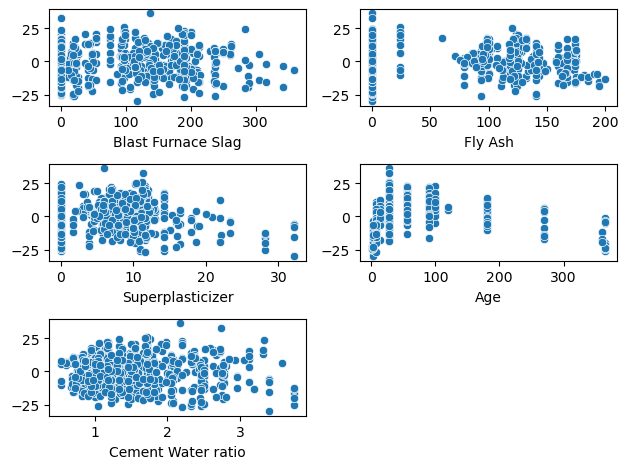

In [24]:
t=1
for i in x_train.columns:
    plt.subplot(3,2,t)
    sns.scatterplot(x=x_train[i],y=base_model.resid)
    t+=1
plt.tight_layout()
plt.show()


In [25]:
#h0: variables are linear
#h1: variables are not linear
p_val=linear_rainbow(base_model)[1]
if p_val<0.05:
    print('reject h0')
else:
    print('fail to reject')

fail to reject


In [26]:
# assumption of Autocorrelation
# durbin watson=1.999 shows there is no autocorrelation

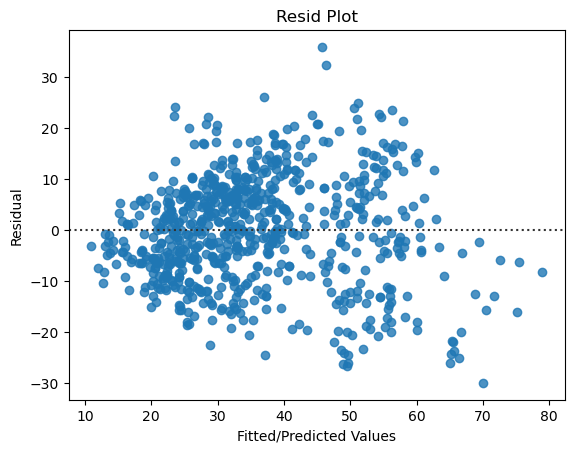

In [27]:
# assumption of homoskedasticity
sns.residplot(x=base_model.fittedvalues,y=base_model.resid)
plt.xlabel('Fitted/Predicted Values')
plt.ylabel('Residual')
plt.title('Resid Plot')
plt.show()

In [28]:
# Goldfeld Quandt test
#H0: the variance is same: homoskedastic
#H1: the variance is not same: heteroskedastic




p_value=sma.stats.diagnostic.het_breuschpagan(resid=base_model.resid,exog_het=base_model.model.exog)[1]
print('p_value',p_value)
if p_value>0.05:
    print('Failed to reject H0')
else:
    print('Reject H0')

p_value 8.589593991139132e-19
Reject H0


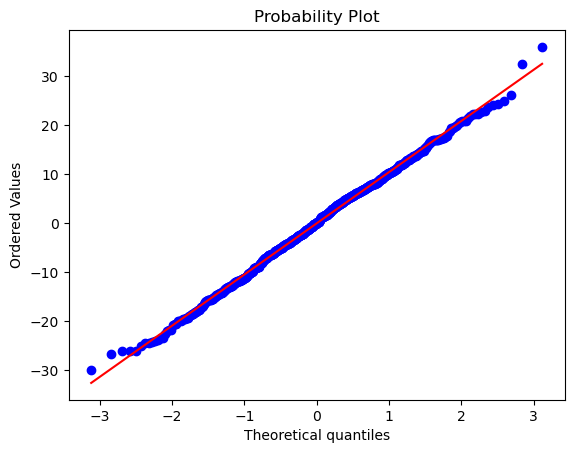

In [29]:
# assumption for normality
stats.probplot(base_model.resid,plot=plt)
plt.show()

# MODEL EVALUATION

In [30]:
def validation(test,pred,data):
    r2=r2_score(test,pred)
    print('R Squared:',r2)
    n=data.shape[0]
    k=data.shape[1]
    r2_adju=1-((1-r2)*(n-1)/(n-k-1))
    print('ADJUSTED R2:',r2_adju)
    print('MSE:',mean_squared_error(test,pred))
    print('RMSE:',np.sqrt(mean_squared_error(test,pred)))
    print('MAE:',mean_absolute_error(test,pred))
    print('MAPE:',mean_absolute_percentage_error(test,pred))

In [31]:
pred_train=base_model.predict(x_train_c)

In [32]:
validation(y_train,pred_train,x_train_c)

R Squared: 0.5970851441472326
ADJUSTED R2: 0.5938445420894356
MSE: 108.53226979306343
RMSE: 10.4178822124779
MAE: 8.40675193856409
MAPE: 0.32331536545837347


In [33]:
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CCS   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     221.4
Date:                Fri, 10 Nov 2023   Prob (F-statistic):          8.90e-145
Time:                        08:59:21   Log-Likelihood:                -2833.1
No. Observations:                 753   AIC:                             5678.
Df Residuals:                     747   BIC:                             5706.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -11.1731      1.805     -6.191      0.000     -14.716      -7.630
Blast Furnace Slag     0.0820      0.006     14.118      0.000       0.071       0.093
Fly Ash                0.0856      0.009      9.250      0.000       0.067       0.104
Superplasticizer       0.1808      0.090      2.017      0.044       0.005       0.357
Age                    0.1005      0.006     17.660      0.000       0.089       0.112
Cement Water ratio    19.2583      0.876     21.978      0.000      17.538      20.978
==============================================================================
Omnibus:                        0.703   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.704   Jarque-Bera (JB):                0.796
Skew:                          -0.045   Prob(JB):                        0.672
Kurtosis:                       2.868   Cond. No.                         633.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
pred_test=base_model.predict(x_test_c)

In [35]:
validation(y_test,pred_test,x_test_c)

R Squared: 0.5670892212984748
ADJUSTED R2: 0.5564873246772131
MSE: 108.66925593297188
RMSE: 10.424454706744708
MAE: 8.355986702524989
MAPE: 0.3410804302758685


# CROSS VALIDATION

* k fold CV

In [36]:
lr=LinearRegression()
cross_val=KFold(n_splits=3)
cv_scores=cross_val_score(estimator=lr,X=x,y=y,cv=3,scoring='r2')

In [37]:
cv_scores

array([0.45021923, 0.5321347 , 0.57753016])

In [38]:
import sklearn.metrics as metrics
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'matthews_corrcoef', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'positive_likelihood_ratio', 'neg_negative_likelihood_ratio', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weig

In [39]:
print('AVG R2:',np.mean(cv_scores),'variation in R2',np.std(cv_scores)/np.mean(cv_scores))

AVG R2: 0.5199613635610222 variation in R2 0.10131993012055229


* LOOCV(special case of K-fold)

In [40]:
lr=LinearRegression()
cross_val=LeaveOneOut()
cv_scores=cross_val_score(estimator=lr,X=x,y=y,cv=cross_val,scoring='neg_mean_absolute_percentage_error')

In [41]:
cv_scores

array([-0.3065317 , -0.10004584, -0.44071529, ..., -0.18257283,
       -0.17196701, -0.02006925])

In [42]:
np.abs(np.mean(cv_scores))

0.3276987592860944

# FEATURE SELECTION

In [43]:
sfs=SequentialFeatureSelector(estimator=lr,k_features=4,scoring='r2',cv=3,)

In [44]:
sfs.fit(x_train,y_train)

SequentialFeatureSelector(cv=3, estimator=LinearRegression(), k_features=(4, 4),
                          scoring='r2')

In [45]:
sfs.k_feature_names_

('Blast Furnace Slag', 'Superplasticizer', 'Age', 'Cement Water ratio')

In [46]:
sfs.k_score_

0.5445300897085733

In [47]:
testx=x_test[['Blast Furnace Slag', 'Superplasticizer', 'Age', 'Cement Water ratio']]
trainx=x_train[['Blast Furnace Slag', 'Superplasticizer', 'Age', 'Cement Water ratio']]

In [48]:
lr=LinearRegression()

In [49]:
lr.fit(trainx,y_train)

LinearRegression()

In [50]:
pred_test=lr.predict(testx)

In [51]:
validation(y_test,pred_test,testx)

R Squared: 0.5624137492398523
ADJUSTED R2: 0.5553273322234937
MSE: 109.84289284557045
RMSE: 10.48059601576029
MAE: 8.273738470425652
MAPE: 0.3477963666739814


In [52]:
sfs=SequentialFeatureSelector(estimator=lr,k_features=4,scoring='r2',cv=3,forward=False)

In [53]:
sfs.fit(x_train,y_train)

SequentialFeatureSelector(cv=3, estimator=LinearRegression(), forward=False,
                          k_features=(4, 4), scoring='r2')

In [54]:
sfs.k_feature_names_

('Blast Furnace Slag', 'Fly Ash', 'Age', 'Cement Water ratio')

In [55]:
sfs.k_score_

0.5891270062148529

In [56]:
testx=x_test[['Blast Furnace Slag', 'Fly Ash', 'Age', 'Cement Water ratio']]
trainx=x_train[['Blast Furnace Slag', 'Fly Ash', 'Age', 'Cement Water ratio']]

In [57]:
lr=LinearRegression()

In [58]:
lr.fit(trainx,y_train)

LinearRegression()

In [59]:
pred_test=lr.predict(testx)

In [60]:
validation(y_test,pred_test,testx)

R Squared: 0.5615464074369592
ADJUSTED R2: 0.554445944399501
MSE: 110.06061296943214
RMSE: 10.49097769368671
MAE: 8.37821829507545
MAPE: 0.3405496305623605


# RFE (recursive feature elimination)

In [61]:
base_model.params

const                -11.173110
Blast Furnace Slag     0.081975
Fly Ash                0.085565
Superplasticizer       0.180758
Age                    0.100494
Cement Water ratio    19.258256
dtype: float64

In [62]:
rfe=RFE(estimator=lr,n_features_to_select=4,step=1)

In [63]:
rfe.fit(x_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=4)

In [64]:
rfe.get_feature_names_out()

array(['Fly Ash', 'Superplasticizer', 'Age', 'Cement Water ratio'],
      dtype=object)

In [65]:
pred_train=rfe.predict(x_test)

In [66]:
validation(y_test,pred_train,x_test)

R Squared: 0.4735275599610822
ADJUSTED R2: 0.46282690061069776
MSE: 132.15510248981423
RMSE: 11.495873280869715
MAE: 9.033528868744176
MAPE: 0.3716977812884957


In [67]:
rfecv=RFECV(estimator=lr)

In [68]:
rfecv.fit(x_train,y_train)

RFECV(estimator=LinearRegression())

In [69]:
rfecv.get_feature_names_out()

array(['Blast Furnace Slag', 'Fly Ash', 'Superplasticizer', 'Age',
       'Cement Water ratio'], dtype=object)

In [70]:
rfecv.score(x_test,y_test)

0.5670892212984724